In [1]:
%reload_ext autoreload
%autoreload 2

import os, time
import fcga, fcga_utils
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore



### - LOAD DATA FOR THE FAST CONNECTIVITY GRADIENT APPROXIMATION (FCGA) DEMO
---

In [2]:
data_dir = os.path.join('demo_data')

# example resting-state fMRI data (~60,000 vertices fsLR) from one individual from the NKI Rockland Sample
fmri_data = np.load(os.path.join(data_dir, 'fcga_demo_fmri_data.npy'), allow_pickle=True).item()

# predefined landmark indices for uniformly distributed vertices and grouo parcellations
landmark_data = np.load(os.path.join(data_dir, 'fcga_demo_landmark_data.npy'), allow_pickle=True).item()

uniform_vertices_list = landmark_data['uniform_vertices_list']
group_parcellation_list = landmark_data['group_parcellation_list']
uniform_vertices = landmark_data['uniform_vertices']
group_parcellations = landmark_data['group_parcellations']

surface_data = np.load(os.path.join(data_dir, 'fcga_demo_surface_data_fslr32k.npy'), allow_pickle=True).item()
surf_lh = surface_data['surf_lh']
surf_rh = surface_data['surf_rh']

# load demo fMRI data and get incdices for exluded vertices (e.g. medial_wall)
bold_lh = fmri_data['bold_lh'].astype(np.float64); 
vidx_lh = fmri_data['vidx_lh']
bold_rh = fmri_data['bold_rh'].astype(np.float64); 
vidx_rh = fmri_data['vidx_rh']

n_vert = dict()
n_vert_lh, d = bold_lh.shape
n_vert_rh, d = bold_rh.shape
n_vert_both = n_vert_lh + n_vert_rh
print(f"n_vertices - left hemi {n_vert_lh} - right hemi {n_vert_rh} - both hemis {n_vert_both}")

# stack fMRI data from left and right hemisphere
bold_ts = np.vstack((bold_lh, bold_rh))
print(f"fmri data - n_vertices x n_timepoints {bold_ts.shape}")


n_vertices - left hemi 29669 - right hemi 29632 - both hemis 59301
fmri data - n_vertices x n_timepoints (59301, 200)


### - GET GRADIENTS BASED ON THE FULL CONNECTIVITY MATRIX
---
use **rerun_grad_full = False** to load precomputed gradients based on the full connectivity matrix data\
use **rerun_grad_full = True** to calculate gradients based on the full connectivity matrix

In [3]:
# ===============================================
n_grads = 25
rerun_grad_full = False # set to True or False
# ===============================================

if rerun_grad_full:
    t = time.time()
    print('run gradients based on full fc ...')
    grad_full, lambdas_full = fcga.do_fastgrads(bold_ts, n_gradients=n_grads)
    print('- done --------------')
    elapsed = time.time() - t
    print(f" time to calculate gradients based on the full fc {elapsed:.2f} sec")
    time_full = elapsed

    # save it for reference
    s = {
        'gradients': grad_full,
        'lambdas': lambdas_full,
        'vidx_lh': vidx_lh,
        'vidx_rh': vidx_rh,
        'time': elapsed
        }
    np.save(f'fcga_demo_gradients_full_ngrads-{n_grads}.npy',s)
else:
    if os.path.exists(f'fcga_demo_gradients_full_ngrads-{n_grads}.npy'):
        # load data that was precomputed
        data = np.load(f'fcga_demo_gradients_full_ngrads-{n_grads}.npy', allow_pickle=True)
        data = data.item()
        grad_full = data['gradients']
        lambdas_full = data['lambdas']
        time_full = data['time']
        vidx_lh = data['vidx_lh']
        vidx_rh = data['vidx_rh']
        print(f"- time to calculate gradients based on the full fc {data['time']:.2f} sec")
    else:
        print(f"FULL FC DATA DOES NOT EXIST - ({f'fcga_demo_gradients_full_ngrads-{n_grads}.npy'})\nrun cell with rerun_grad_full = True")


run gradients based on full fc ...
#landmarks: 59301
fmri data shape: (59301, 200)
affinity matrix shape: (59301, 59301)
- done --------------
 time to calculate gradients based on the full fc 319.62 sec


### - RUN FCGA WITH DIFFERENT LANDMARKS
---

get targets - done
- time to get landmarks 0.00 sec
run fcga ----------------------------------
#landmarks: 892
fmri data shape: (59301, 200)
affinity matrix shape: (59301, 892)
- done ------------------------------------
-  time to calculate gradients with FCGA 2.87 sec (vs full fc 319.62 sec)
- do Procrustes to correct for order and sign flips
average similarity of first 25 gradients: r = 0.94


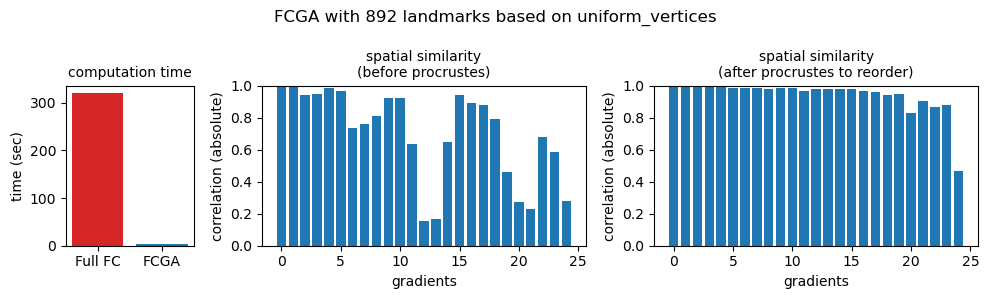

In [12]:
# "random_vertices", "uniform_vertices", "parcellation"
landmark_type = 'uniform_vertices'

t = time.time()
print('get targets', end=' ')

if (landmark_type == "random_vertices"):
    n_landmarks = 500 # landmarks are per hemisphere
    landmark_ts = fcga.get_random_targets(bold_ts, n_landmarks=n_landmarks, vidx_lh=vidx_lh, vidx_rh=vidx_rh) 
elif (landmark_type == "uniform_vertices"):
    # choices for n_landmarks are [252, 492, 642, 1002, 1442, 1962, 2562]
    n_landmarks = 492 # landmarks are per hemisphere
    landmark_ts = fcga.get_uniform_targets(bold_ts, uniform_vertices, n_landmarks=n_landmarks, vidx_lh=vidx_lh, vidx_rh=vidx_rh) 
elif (landmark_type == "parcellation"):
    # choices for parc_landmarks are ['gordon333', 'glasser', 'schaefer100', 'schaefer200', 'schaefer400', 'schaefer600', 'schaefer800', 'schaefer1000']
    parc_landmarks = 'schaefer1000'
    landmark_ts = fcga.get_regionbased_targets(bold_ts, group_parcellations, landmarks=parc_landmarks, vidx_lh=vidx_lh, vidx_rh=vidx_rh) 
    landmark_type = landmark_type+f"-{parc_landmarks}"
else:
    print("no landmarks selected")

n_lm, _ = landmark_ts.shape

print('- done')
elapsed = time.time() - t
print(f"- time to get landmarks {elapsed:.2f} sec")

t = time.time()
print('run fcga ----------------------------------')
grad_fcga, lambdas_fcga = fcga.do_fastgrads(bold_ts, landmarks_ts=landmark_ts, n_gradients=n_grads)
print('- done ------------------------------------')
elapsed = time.time() - t
print(f"-  time to calculate gradients with FCGA {elapsed:.2f} sec (vs full fc {time_full:.2f} sec)")
time_fcga = elapsed

print("- do Procrustes to correct for order and sign flips")
grad_fcga_aligned, transformation = fcga.procrustes(grad_fcga, grad_full)

similarity_fcga_aligned = np.array([ np.corrcoef(grad_full[:,x], grad_fcga_aligned[:,x])[0,1] for x in np.arange(25)])
print(f"average similarity of first 25 gradients: r = {np.nanmean(similarity_fcga_aligned):.2f}")

plot_title = f"FCGA with {n_lm} landmarks based on {landmark_type}"
fcga_utils.visualize_comparison(grad_full, grad_fcga, grad_fcga_aligned, time_full, time_fcga, title_str=plot_title)



### - VISUALIZE AND COMPARE CONNECTIVITY GRADIENTS

In [ ]:
visu_grad = 0
print(f"visualize gradient {visu_grad}")
fcga_utils.visualize_gradients(grad_full, grad_fcga_aligned, visu_grad, surf_lh, vidx_lh)